In [1]:
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("../../data/hindi_dataset/hindi_dataset.tsv",sep="\t")
data.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_hi_5556,"बांग्लादेश की शानदार वापसी, भारत को 314 रन पर ...",NOT,NONE,NONE
1,hasoc_hi_5648,सब रंडी नाच देखने मे व्यस्त जैसे ही कोई #शांती...,HOF,PRFN,UNT
2,hasoc_hi_164,तुम जैसे हरामियों के लिए बस जूतों की कमी है शु...,HOF,PRFN,TIN
3,hasoc_hi_3530,"बीजेपी MLA आकाश विजयवर्गीय जेल से रिहा, जमानत ...",NOT,NONE,NONE
4,hasoc_hi_5206,चमकी बुखार: विधानसभा परिसर में आरजेडी का प्रदर...,NOT,NONE,NONE


In [3]:
test_data = pd.read_csv("../../data/hindi_dataset/hasoc2019_hi_test_gold_2919.tsv", sep="\t")
test_data.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_hi_5061,"वक्त, इन्सान और इंग्लैंड का मौसम आपको कभी भी ध...",NOT,NONE,NONE
1,hasoc_hi_2090,#कांग्रेस के इस #कमीने की #करतूत को देखिए देश ...,HOF,OFFN,TIN
2,hasoc_hi_2960,पाकिस्तान को फेकना था फेका गया। जो हार कर भी द...,HOF,OFFN,TIN
3,hasoc_hi_864,जो शब्द तूम आज किसी और औरत के लिए यूज कर रहे व...,NOT,NONE,NONE
4,hasoc_hi_54,नेता जी हम समाजवादी सिपाही हमेशा आपके साथ है आ...,NOT,NONE,NONE


In [4]:
# label_task1, label_task2, label_task3 = {'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2}, {'TIN':0, 'UNT':1}
label = [{'NOT': 0, 'HOF': 1}, {'HATE':0, 'OFFN':1, 'PRFN':2, 'NONE':3}, {'TIN':0, 'UNT':1, 'NONE':2}]

In [5]:
def create_label(labels, data):
    return data.map(labels, na_action='ignore')

In [6]:
def create_model(n_class):
    print("CLASSES:", n_class)
    model = Sequential()
    model.add(Dense(768, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(n_class, activation='softmax'))
    return model

In [7]:
def make_train(model, X_train, X_test, y_train, y_test, X_val, y_val, epochs=5, batch_size=32):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=True)
    results = model.evaluate(X_test, y_test)
    print("test loss, test acc:", results)
    return history.history, epochs

In [8]:
from bert import bert_tokenization
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub


def create_input(input_strings, tokenizer, max_seq_length):

  input_ids_all, input_mask_all, input_type_ids_all = [], [], []
  for input_string in input_strings:

    # Tokenize input.
    input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
    sequence_length = min(len(input_ids), max_seq_length)

    # Padding or truncation.
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    input_type_ids_all.append([0] * max_seq_length)

  return np.array(input_ids_all), np.array(input_mask_all), np.array(input_type_ids_all)

def embed(input_text):
  input_ids, input_mask, input_type_ids = create_input(
    input_text, tokenizer, max_seq_length)

  inputs = dict(
      input_word_ids=input_ids,
      input_mask=input_mask,
      input_type_ids=input_type_ids,
  )
  return muril_model(inputs)

# sentences = ["Puppies are nice", "मैंने उससे दोबारा बात नहीं की है.", "ਮੌਸਮ ਬਹੁਤ ਵਧੀਆ ਹੈ", "ఈ రోజు చాలా చల్లగా ఉంది" ]

# embeddings = embed(sentences)
# print(embeddings)

In [9]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import tensorflow_hub as hub
# import tensorflow_text as text

def get_model(model_url, max_seq_length):

  # Define input.
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
  )

  # Define muril layer.
  muril_layer = hub.KerasLayer(model_url, trainable=True)
  outputs = muril_layer(inputs)

  # The encoder outputs are a dict of tensors with the following keys

  # 'sequence_output' : A float32 Tensor of shape [batch_size, seq_len, dim] with the Transformer encoder’s final output for each position in the input_sequence.
  assert 'sequence_output' in outputs

  # 'pooled_output' : A float32 Tensor of shape [batch_size, dim] that provides a 1-D representation for each input by a trained aggregation of sequence outputs.
  assert 'pooled_output' in outputs

  # 'encoder_outputs' : A list of tensors, each of which corresponds to the output of a transformer layer.
  assert 'encoder_outputs' in outputs

  # ' default' : alias for 'pooled_output'
  assert 'default' in outputs

  # Define model.
  return tf.keras.Model(inputs=inputs,outputs=outputs["pooled_output"]), muril_layer


max_seq_length = 128
muril_model, muril_layer = get_model(
    model_url="https://tfhub.dev/google/MuRIL/1", max_seq_length=max_seq_length)

vocab_file = muril_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = muril_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


=== Training embedding done ====
=== Testing embedding done ====
=== Validation embedding done ====
CLASSES: 2
Epoch 1/5
98/98 [==============================] - 2s 15ms/step - loss: 0.6941 - accuracy: 0.5113 - val_loss: 0.6905 - val_accuracy: 0.5351
Epoch 2/5
98/98 [==============================] - 1s 5ms/step - loss: 0.6924 - accuracy: 0.5190 - val_loss: 0.6902 - val_accuracy: 0.5351
Epoch 3/5
98/98 [==============================] - 1s 5ms/step - loss: 0.6933 - accuracy: 0.5165 - val_loss: 0.6902 - val_accuracy: 0.5351
Epoch 4/5
98/98 [==============================] - 1s 5ms/step - loss: 0.6907 - accuracy: 0.5402 - val_loss: 0.6891 - val_accuracy: 0.5351
Epoch 5/5
42/42 [==============================] - 0s 2ms/step - loss: 0.7053 - accuracy: 0.4590
test loss, test acc: [0.7053298950195312, 0.45902884006500244]


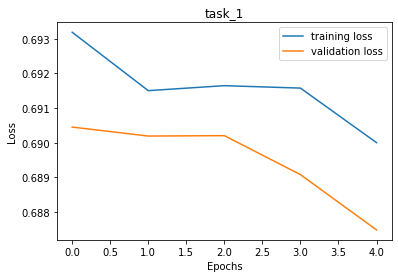

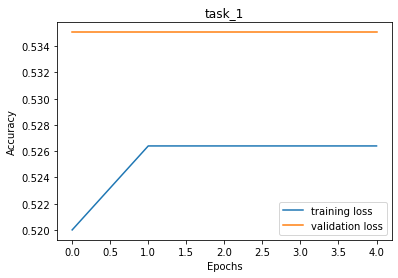

=== Training embedding done ====
=== Testing embedding done ====
=== Validation embedding done ====
CLASSES: 4
Epoch 1/5
98/98 [==============================] - 2s 17ms/step - loss: 1.2761 - accuracy: 0.4453 - val_loss: 1.2519 - val_accuracy: 0.4649
Epoch 2/5
98/98 [==============================] - 1s 5ms/step - loss: 1.2235 - accuracy: 0.4886 - val_loss: 1.2542 - val_accuracy: 0.4649
Epoch 3/5
98/98 [==============================] - 0s 5ms/step - loss: 1.2336 - accuracy: 0.4774 - val_loss: 1.2488 - val_accuracy: 0.4649
Epoch 4/5
98/98 [==============================] - 0s 5ms/step - loss: 1.2365 - accuracy: 0.4698 - val_loss: 1.2479 - val_accuracy: 0.4649
Epoch 5/5
42/42 [==============================] - 0s 2ms/step - loss: 1.2152 - accuracy: 0.5410
test loss, test acc: [1.2152329683303833, 0.5409711599349976]


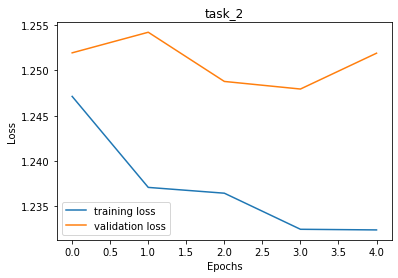

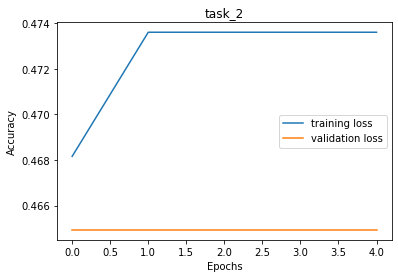

=== Training embedding done ====
=== Testing embedding done ====
=== Validation embedding done ====
CLASSES: 3
Epoch 1/5
98/98 [==============================] - 1s 9ms/step - loss: 1.0601 - accuracy: 0.4236 - val_loss: 1.0412 - val_accuracy: 0.4649
Epoch 2/5
98/98 [==============================] - 1s 5ms/step - loss: 1.0421 - accuracy: 0.4807 - val_loss: 1.0406 - val_accuracy: 0.4649
Epoch 3/5
98/98 [==============================] - 1s 5ms/step - loss: 1.0451 - accuracy: 0.4611 - val_loss: 1.0403 - val_accuracy: 0.4649
Epoch 4/5
98/98 [==============================] - 1s 5ms/step - loss: 1.0354 - accuracy: 0.4842 - val_loss: 1.0378 - val_accuracy: 0.4649
Epoch 5/5
42/42 [==============================] - 0s 2ms/step - loss: 0.9548 - accuracy: 0.5410
test loss, test acc: [0.9547869563102722, 0.5409711599349976]


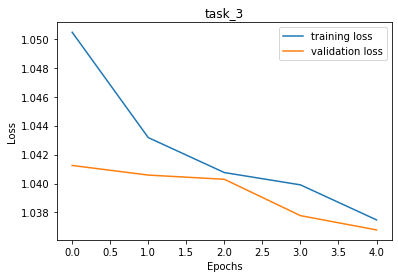

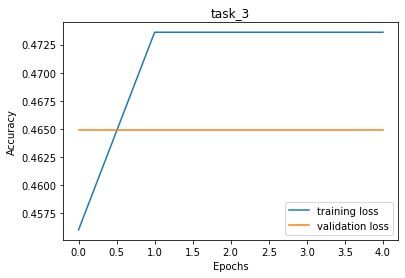

In [10]:
for i in range(1,4):
    col = "task_"+str(i)
    y = create_label(label[i-1], data[col])
    x = data['text']
    
    y_test, X_test = create_label(label[i-1], test_data[col]), test_data['text']
    
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
    
    X_train_embed = embed(X_train)
    print("=== Training embedding done ====")
    X_test_embed = embed(X_test)
    print("=== Testing embedding done ====")
    X_val_embed = embed(X_val)
    print("=== Validation embedding done ====")
    
    model = create_model(n_class = len(label[i-1]))
    history, epochs = make_train(model, X_train_embed, X_test_embed, y_train, y_test, X_val_embed, y_val)
    p_y = np.arange(epochs)
    plt.plot(p_y, history['loss'])
    plt.plot(p_y, history['val_loss'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(col)
    plt.show()
    
    plt.plot(p_y, history['accuracy'])
    plt.plot(p_y, history['val_accuracy'])
    plt.legend(['training loss','validation loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(col)
    plt.show()